In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Convolutional neural networks

In class, we have briefly reviewed the idea of learning good features directly from data and went through the concept of convolutional neural networks along with few architectures.

Until recently, building convolutional neural networks was tough. There was no high-level tools for that, you would be required to understand all the internal mechanics of the model and its operations.

Today, due to the high-level tools such as Keras and TensorFlow, everybody can build a convolutional neural network and put it to work without diving deep into them. What used to be a one-month project became a few hours exercise.


In [62]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import plaidml.keras
plaidml.keras.install_backend()

import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers import Flatten
from keras.layers import BatchNormalization

from keras.optimizers import SGD

from keras.utils import np_utils

from keras.backend import resize_images

from keras.datasets import cifar10

## Loading the images

In [38]:
(train_images, train_labels), (cv_images, cv_labels) = cifar10.load_data()

train_images = np.array(train_images)
train_labels = np_utils.to_categorical(np.array(train_labels), 10)

cv_images = np.array(cv_images)
cv_labels = np_utils.to_categorical(np.array(cv_labels), 10)

In [39]:
print(train_images.shape)
print(len(train_labels))

(50000, 32, 32, 3)
50000


In [40]:
print(cv_images.shape)
print(len(cv_labels))

(10000, 32, 32, 3)
10000


In [41]:
print(train_labels[0:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [42]:
def show_image(np_array):
    %matplotlib inline
    plt.figure()
    plt.imshow(np_array)

In [43]:
def show_example(data_set, labels, example_index):
    show_image(data_set[example_index])
    print('Label: ', labels[example_index])

Label:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


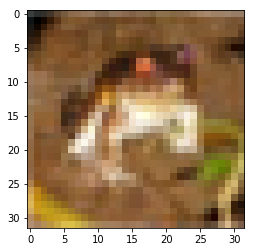

In [44]:
show_example(train_images, train_labels, example_index = 0)

Label:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


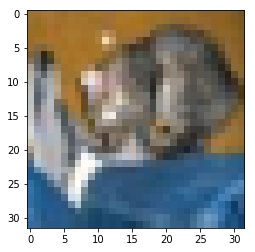

In [45]:
show_example(cv_images, cv_labels, example_index = 0)

## Building AlexNet

In 2012 a convolutional neural network called AlexNet won ImageNet competition. 

Go through an [original AlexNet paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) to investigate the architecture. Next, investigate the [basics of Keras](https://keras.io/#keras-the-python-deep-learning-library). We will use it with TensorFlow backend.

You are also encouraged to go through some CNN tutorial for Keras. There is a number of them online (for example, [this](https://elitedatascience.com/keras-tutorial-deep-learning-in-python) or [this](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)).
Now, build AlexNex network with Keras for object recognition. Note that standard AlexNet works with 224x224 input images. The dataset you are going to use for this problem is 32x32.

In [48]:
model = Sequential()

# Layer 0
# resize images to have the same input as in the AlexNet
model.add(Lambda(lambda image: resize_images(image, height_factor=7, width_factor=7, data_format='channels_last'), input_shape=(32,32,3), output_shape=(54,54,3)))

# AlexNet layers description here: https://sushscience.wordpress.com/2016/12/04/understanding-alexnet/
# Keras layers docs: https://keras.io/layers/core/

# Layer 1
model.add(Conv2D(filters=48, kernel_size=(11,11), strides=4, activation='relu', padding='same'))

# Layer 2
model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'))

# Layer 3
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=192, kernel_size=(3,3), activation='relu', padding='same'))

# Layer 4
model.add(Conv2D(filters=192, kernel_size=(3,3), activation='relu', padding='same'))

# Layer 5
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))

# Layer 6
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(2048, activation = 'relu'))

# Layer 7
model.add(Dense(2048, activation = 'relu'))

# Layer 8
model.add(Dense(10, activation = 'softmax'))

print(model.summary())

model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_17 (Lambda)           (None, 54, 54, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 48)        3648      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 64)          76864     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 96)          55392     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 96)          83040     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 64)          55360     
__________

## Training AlexNet

Use training set for training the network to recognize objects. You might want to use RMSProp optimizer to speed up the training.

Convolutional networks require a lot of computing power for training. Typical setup for training CNN is to use GPU, however, in this problem you are not required to do so. CPU will be fine as well.

If you are using CPU for this subproblem, training process might be slow. You can stop it manually as soon as you get meaningful results.

Report the results on the training and cross-validation sets. The report should contain the training logs.

In [49]:
model.fit(train_images, train_labels, batch_size=64, epochs=100, initial_epoch=0, verbose=1, validation_data=(cv_images, cv_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 29s 574us/step - loss: 1.6539 - acc: 0.4049 - val_loss: 1.4542 - val_acc: 0.4832
Epoch 2/100
50000/50000 [==============================] - 28s 555us/step - loss: 1.2915 - acc: 0.5400 - val_loss: 1.2476 - val_acc: 0.5457
Epoch 3/100
50000/50000 [==============================] - 28s 556us/step - loss: 1.1636 - acc: 0.5878 - val_loss: 1.2349 - val_acc: 0.5659
Epoch 4/100
50000/50000 [==============================] - 27s 550us/step - loss: 1.0616 - acc: 0.6276 - val_loss: 1.1818 - val_acc: 0.5844
Epoch 5/100
50000/50000 [==============================] - 28s 562us/step - loss: 0.9888 - acc: 0.6513 - val_loss: 1.0597 - val_acc: 0.6342
Epoch 6/100
50000/50000 [==============================] - 28s 560us/step - loss: 0.9344 - acc: 0.6705 - val_loss: 1.0959 - val_acc: 0.6247
Epoch 7/100
50000/50000 [==============================] - 28s 554us/step - loss: 0.8877 - acc: 0.6906 - val_l

KeyboardInterrupt: 

In [ ]:
# save and load models: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

def save_model(model, model_name):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + ".h5")
    print('Saved', model_name, 'to disk')

In [ ]:
save_model(model, 'model')

### Summary
The best accuracy on the test set is 0.6167 (epoch 33).

## Improving AlexNet

As you can see, AlexNet does not work very well on such a small dataset. Recall what you have learned from this class to improve its performance. You can also take a look at the [Dropout technique](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) and its [implementation in Keras](https://keras.io/layers/core/#dropout). 

In [76]:
dropout_model = Sequential()

# Layer 0
# resize images to have the same input as in the AlexNet
dropout_model.add(Lambda(lambda image: resize_images(image, height_factor=2, width_factor=2, data_format='channels_last'), input_shape=(32,32,3), output_shape=(64,64,3)))

dropout_model.add(BatchNormalization())

# AlexNet layers description here: https://sushscience.wordpress.com/2016/12/04/understanding-alexnet/
# Keras layers docs: https://keras.io/layers/core/

# Layer 1
dropout_model.add(Conv2D(filters=48, kernel_size=(5,5), strides=4, activation='relu', padding='same'))

# Layer 2
dropout_model.add(MaxPooling2D(pool_size=(2,2)))
dropout_model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'))

# Layer 3
# model.add(MaxPooling2D(pool_size=(2,2)))
dropout_model.add(Conv2D(filters=96, kernel_size=(3,3), activation='relu', padding='same'))

# Layer 4
dropout_model.add(Conv2D(filters=96, kernel_size=(3,3), activation='relu', padding='same'))

# Layer 5
dropout_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))

# Layer 6
dropout_model.add(MaxPooling2D(pool_size=(2,2)))
dropout_model.add(Flatten())
dropout_model.add(Dense(256, activation = 'relu'))
# dropout_model.add(Dropout(0.2))

# Layer 7
dropout_model.add(Dense(256, activation = 'relu'))
dropout_model.add(Dropout(0.20))

# Layer 8
dropout_model.add(Dense(10, activation = 'softmax'))

print(dropout_model.summary())

dropout_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_34 (Lambda)           (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 16, 16, 48)        3648      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 8, 8, 64)          76864     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 8, 8, 96)          55392     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 8, 8, 96)          83040     
__________

In [ ]:
dropout_model.fit(train_images, train_labels, batch_size=256, epochs=50, initial_epoch=0, verbose=1, validation_data=(cv_images, cv_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50


INFO:plaidml:Analyzing Ops: 133 of 488 operations complete


49920/50000 [============================>.] - ETA: 0s - loss: 1.6072 - acc: 0.4080

INFO:plaidml:Analyzing Ops: 139 of 488 operations complete


50000/50000 [==============================] - 48s 961us/step - loss: 1.6069 - acc: 0.4081 - val_loss: 1.3866 - val_acc: 0.5025
Epoch 2/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.2119 - acc: 0.5656 - val_loss: 1.1621 - val_acc: 0.5872
Epoch 3/50
50000/50000 [==============================] - 29s 586us/step - loss: 1.0272 - acc: 0.6367 - val_loss: 1.0120 - val_acc: 0.6447
Epoch 4/50
50000/50000 [==============================] - 29s 585us/step - loss: 0.9014 - acc: 0.6841 - val_loss: 0.8994 - val_acc: 0.6856
Epoch 5/50
50000/50000 [==============================] - 29s 586us/step - loss: 0.7992 - acc: 0.7199 - val_loss: 0.8509 - val_acc: 0.6966
Epoch 6/50
50000/50000 [==============================] - 29s 587us/step - loss: 0.7174 - acc: 0.7509 - val_loss: 0.8282 - val_acc: 0.7159
Epoch 7/50
50000/50000 [==============================] - 29s 584us/step - loss: 0.6456 - acc: 0.7743 - val_loss: 0.8225 - val_acc: 0.7169
Epoch 8/50
50000/50000 [==============

In [ ]:
save_model(dropout_model, 'dropout_model')

### Summary
The best accuracy on the test set is 0.6199 (epoch 27).